In [1]:
#
# PyOpenPNL example notebook / adult income analysis dataset
# Copyright 2017, Tim O'Shea
#

In [2]:
import time, os, csv, copy, pprint, openpnl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
t0 = time.time()
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:


# Fetch the dataset if needed ....
filename = 'adult.csv'
if not os.path.isfile(filename):
    import urllib2
    resp = urllib2.urlopen('http://www.openmarkov.org/learning/datasets/adult.csv')
    fd = open(filename,'w') 
    fd.write(resp.read())
    fd.close()
    
    

In [4]:


# Load the dataset
fd = open(filename,'r')
fr = csv.reader(fd,delimiter=',')

# Load in the headers to choose from ...
all_node_names = fr.next()
print "All Available Nodes"
for i in range(0, len(all_node_names)):
    print i, all_node_names[i]


All Available Nodes
0 Age
1  workclass
2  fnlwgt
3  education
4  education-num
5  marital-status
6  occupation
7  relationship
8  race
9  sex
10  capital-gain
11  capital-loss
12  hours-per-week
13  native-country
14  class


In [5]:
# # Select which fields from the csv to use
#node_idx =   [1,2,3,4,5,6,8,9,10,11,12,14]
node_idx =   [0,1,3,4,5,6,7,9,10,11,12,14]
node_names = map(lambda x: all_node_names[x], node_idx)
pprint.pprint(zip(range(0,len(node_names)),node_names))

[(0, 'Age'),
 (1, ' workclass'),
 (2, ' education'),
 (3, ' education-num'),
 (4, ' marital-status'),
 (5, ' occupation'),
 (6, ' relationship'),
 (7, ' sex'),
 (8, ' capital-gain'),
 (9, ' capital-loss'),
 (10, ' hours-per-week'),
 (11, ' class')]


In [6]:

# fields describing the dataset...
node_vals  = {}
node_card  = {}
node_numeric = {}
max_cardinality = 10

# populate node names
for k in node_names:
    node_vals[k] = set([])
    
# populate node values
records = []
for r in fr:
    if len(r) > 0:
        use_rec = map(lambda x: r[x], node_idx)
        records.append(use_rec)
        for i,k in enumerate(node_names):
            node_vals[k].update([r[node_idx[i]]])
            

# convert back to lists
for k in node_names:
    node_vals[k] = list(node_vals[k])
    

# populate node cardinality
for k in node_names:
    node_card[k] = len(node_vals[k])

print "Node Cardinality:"    
pprint.pprint(node_card)

def is_numeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Find numeric fields
for k in node_names:
    is_num = True
    node_numeric[k] = True
    for v in node_vals[k]:
        if not is_numeric(v):
            node_numeric[k] = False
            
print "Node Numeric:"    
pprint.pprint(node_numeric)

# Quantize fields which meet our criteria ( is_numeric && card > max_card )
qrecords = copy.copy(records)
print node_names
for i,k in enumerate(node_names):
    if node_numeric[k] and node_card[k] > max_cardinality:
        print "Quantize field: ", i, k, " %d -> %d "%( node_card[k], max_cardinality )
        old_vals = np.array(map(lambda x: float(x[i]), records))        
        bins = np.linspace(min(old_vals), max(old_vals), max_cardinality-1)
        newvals = np.digitize(old_vals, bins, right=True)
        binstr = ['<%0.02f'%(bins[0])]
        for j in range(0,len(bins)-1):
            binstr.append("%0.02f-%0.02f"%(bins[j],bins[j+1]))
        node_vals[k] = binstr
        for j in range(0,len(qrecords)):
            qrecords[j][i] = binstr[newvals[j]]
        
        node_card[k] = max_cardinality
        node_vals[k] = binstr

        

Node Cardinality:
{' capital-gain': 119,
 ' capital-loss': 92,
 ' class': 2,
 ' education': 16,
 ' education-num': 16,
 ' hours-per-week': 94,
 ' marital-status': 7,
 ' occupation': 15,
 ' relationship': 6,
 ' sex': 2,
 ' workclass': 9,
 'Age': 73}
Node Numeric:
{' capital-gain': True,
 ' capital-loss': True,
 ' class': False,
 ' education': False,
 ' education-num': True,
 ' hours-per-week': True,
 ' marital-status': False,
 ' occupation': False,
 ' relationship': False,
 ' sex': False,
 ' workclass': False,
 'Age': True}
['Age', ' workclass', ' education', ' education-num', ' marital-status', ' occupation', ' relationship', ' sex', ' capital-gain', ' capital-loss', ' hours-per-week', ' class']
Quantize field:  0 Age  73 -> 10 
Quantize field:  3  education-num  16 -> 10 
Quantize field:  8  capital-gain  119 -> 10 
Quantize field:  9  capital-loss  92 -> 10 
Quantize field:  10  hours-per-week  94 -> 10 


In [7]:
# Convert dataset to numeric form
X = np.zeros([len(qrecords), len(node_names)], dtype='int32')
for i in range(0,len(qrecords)):
    for j in range(0,len(node_names)):
        X[i,j] = node_vals[node_names[j]].index(qrecords[i][j])

In [8]:


# BN Structure Learning
max_fan_in = 1
n_restarts = 100
bn = openpnl.mkSkelBNet(map(lambda x: node_card[x], node_names))
sl = openpnl.mkCMlStaticStructLearnHC(bn, max_fan_in, n_restarts)
sl.SetPyData(bn, X)
a = time.time()
sl.Learn();
b = time.time()
print "Structure Learning Time: %f (s) "%(b-a)


Structure Learning Time: 1.475881 (s) 


Learned Adjacency Matrix
[[0 0 1 1 1 1 1 0 0 0 0 0]
 [0 0 1 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0 0 1]
 [0 0 1 1 0 1 1 0 0 0 0 1]
 [1 0 1 1 1 1 1 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0 0 0]]
DAG Plot


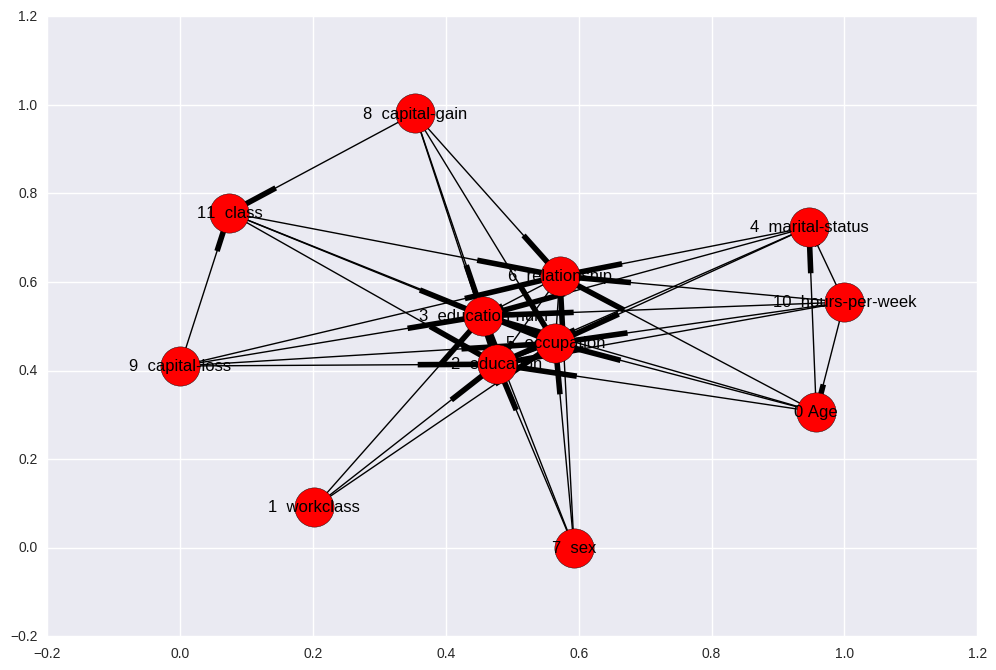

In [9]:
dag = sl.GetResultDAG();
adjMat = dag.adjMatrix(len(node_names)**2).reshape([len(node_names),len(node_names)])
print "Learned Adjacency Matrix"
print adjMat
import networkx as nx
G = nx.DiGraph(adjMat)

namemap = dict(zip(range(0,len(node_names)), map(lambda x,y: str(x)+" "+y, range(0,len(node_names)),node_names)))

print "DAG Plot"
lay = nx.spring_layout(G)

plt.figure(figsize=(12,8))
nx.draw_networkx(G, 
                 pos=lay, 
                 labels=namemap,
                 arrows=True,
                 node_size=800)

In [10]:
edges = [(7,6),(7,5),
         (11,3),(11,6),
         (0,4),(0,2),
         (1,2),(1,5),
         (10,5),
         (8,5),(9,5),
         (8,0),(9,0),
         (10,8),
        ]

[[0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0]]
DAG Plot


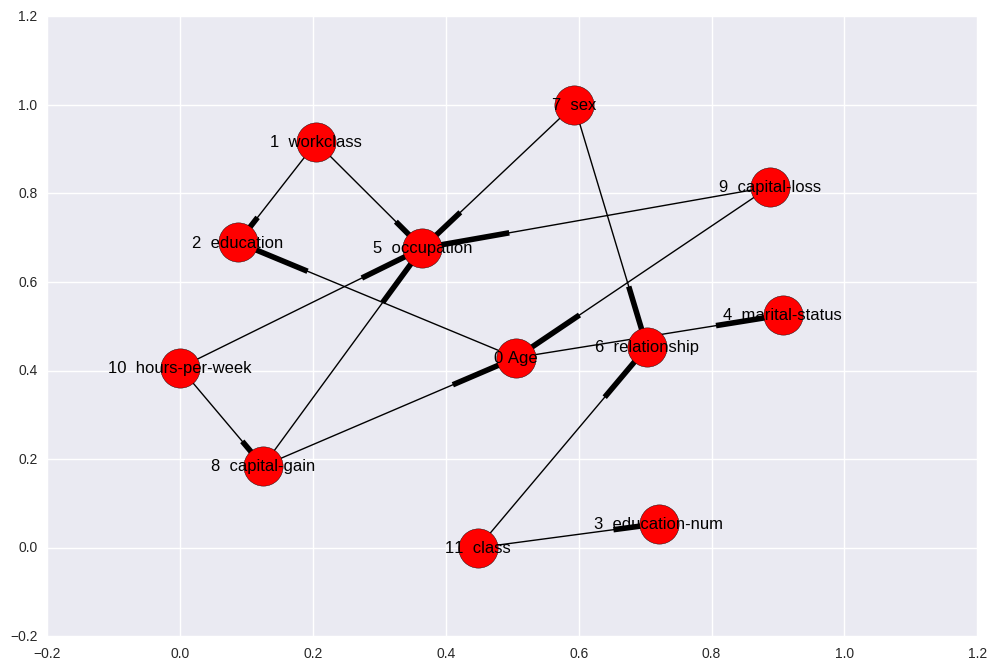

In [11]:
#Specified Adj Matrix
numNodes = 12
adjMat2 = np.zeros( (numNodes, numNodes), dtype=np.int32 )

for i,j in edges:
    adjMat2[i,j] = 1
print adjMat2

G = nx.DiGraph(adjMat2)
namemap = dict(zip(range(0,len(node_names)), map(lambda x,y: str(x)+" "+y, range(0,len(node_names)),node_names)))
print "DAG Plot"
plt.figure(figsize=(12,8))
nx.draw_networkx(G, 
                 pos=nx.spring_layout(G), 
                 labels=namemap,
                 arrows=True,
                 node_size=800)

In [12]:
from functools import reduce as _reduce
import copy
__all__ = ['toposort', 'toposort_flatten']

def toposort(data):
    """Dependencies are expressed as a dictionary whose keys are items
and whose values are a set of dependent items. Output is a list of
sets in topological order. The first set consists of items with no
dependences, each subsequent set consists of items that depend upon
items in the preceeding sets.
"""

    # Special case empty input.
    if len(data) == 0:
        return

    # Copy the input so as to leave it unmodified.
    data = data.copy()

    # Ignore self dependencies.
    for k, v in data.items():
        v.discard(k)
    # Find all items that don't depend on anything.
    extra_items_in_deps = _reduce(set.union, data.values()) - set(data.keys())
    # Add empty dependences where needed.
    data.update({item:set() for item in extra_items_in_deps})
    while True:
        ordered = set(item for item, dep in data.items() if len(dep) == 0)
        if not ordered:
            break
        yield ordered
        data = {item: (dep - ordered)
                for item, dep in data.items()
                    if item not in ordered}
    if len(data) != 0:
        raise ValueError('Cyclic dependencies exist among these items: {}'.format(', '.join(repr(x) for x in data.items())))


def toposort_flatten(data, sort=True):
    """Returns a single list of dependencies. For any set returned by
toposort(), those items are sorted and appended to the result (just to
make the results deterministic)."""

    result = []
    for d in toposort(data):
        result.extend((sorted if sort else list)(d))
    return result

In [13]:
edgedict = {}
for s,d in edges:
    if edgedict.has_key(s):
        edgedict[s].append(d)
    else:
        edgedict[s] = [d]
for k in edgedict.keys():
    edgedict[k] = set(edgedict[k])
print edgedict
topo_mapping = toposort_flatten(edgedict)
topo_mapping = topo_mapping[::-1]
print topo_mapping

{0: set([2, 4]), 1: set([2, 5]), 7: set([5, 6]), 8: set([0, 5]), 9: set([0, 5]), 10: set([8, 5]), 11: set([3, 6])}
[10, 9, 8, 11, 7, 1, 0, 6, 5, 4, 3, 2]


In [14]:

adjMat3 = np.zeros( (numNodes, numNodes), dtype=np.int32 )
for i in range(0,numNodes):
    for j in range(0,numNodes):
        adjMat3[i,j] = adjMat2[topo_mapping[i], topo_mapping[j]]


In [15]:

pGraph = openpnl.CGraph.CreateNP(adjMat3)
dag2 = openpnl.CDAG.Create(pGraph)

# set up node types
isDiscrete = True
nA = [0]*(numNodes)

nodeTypes = openpnl.pnlNodeTypeVector()
nodeTypes.resize(numNodes)

for i in range(numNodes):
    node_idx = topo_mapping[i]
    size = node_card[node_names[node_idx]]
    nodeTypes[i].SetType(isDiscrete, len(node_vals[node_names[node_idx]]))
    nA[i] = i
nodeAssociation = openpnl.toConstIntVector(nA)

print dag2.adjMatrix(len(node_names)**2).reshape([len(node_names),len(node_names)])


[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0]
 [1 1 1 0 1 1 0 0 0 0 0 0]
 [1 1 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 1 1 0 0 0 0 0]]


In [16]:
pBNet = openpnl.CBNet.Create( numNodes, nodeTypes, nodeAssociation, dag2 )

In [17]:
pBNet = openpnl.CBNet.CreateWithRandomMatrices(dag2,pBNet.GetModelDomain())

In [18]:
# CPD Learning
pl = openpnl.CEMLearningEngine.Create(pBNet)
pl.SetPyData(pBNet, X[:,topo_mapping])
pl.SetMaxIterEM(500)
a = time.time()
pl.Learn()
b = time.time()
print "CPD Learning Time: %f (s) "%(b-a)

bn = pBNet

CPD Learning Time: 0.112968 (s) 


In [19]:
pprint.pprint(node_vals)

{' capital-gain': ['<0.00',
                   '0.00-12499.88',
                   '12499.88-24999.75',
                   '24999.75-37499.62',
                   '37499.62-49999.50',
                   '49999.50-62499.38',
                   '62499.38-74999.25',
                   '74999.25-87499.12',
                   '87499.12-99999.00'],
 ' capital-loss': ['<0.00',
                   '0.00-544.50',
                   '544.50-1089.00',
                   '1089.00-1633.50',
                   '1633.50-2178.00',
                   '2178.00-2722.50',
                   '2722.50-3267.00',
                   '3267.00-3811.50',
                   '3811.50-4356.00'],
 ' class': [' >50K', ' <=50K'],
 ' education': [' 7th-8th',
                ' Prof-school',
                ' 1st-4th',
                ' Assoc-voc',
                ' Masters',
                ' Assoc-acdm',
                ' 9th',
                ' Doctorate',
                ' Bachelors',
                ' 5th-6th',
      

In [20]:

def sample_density(enum=[0], evidence = {}):
    
    # Inference engines choice should be interchangable
    # 
    #infeng = openpnl.CNaiveInfEngine.Create( bn )
    infeng = openpnl.CJtreeInfEngine.Create( bn )
    #infeng = openpnl.CPearlInfEngine.Create( bn )
    
    enum_idx = map(lambda x: topo_mapping.index(x), enum)

    ev = {}
    if(len(evidence)>0):
        nodes = list(evidence.keys())
        vals = list(evidence.values())
        
        node_idxs = map(lambda x: topo_mapping.index(x), nodes)
        
        a = np.vstack([node_idxs,vals]).astype('int32')
        infeng.enterEvidence(bn, a)
        
        for k,v in evidence.iteritems():
            nodename = node_names[k]
            nodeval =  node_vals[nodename][v]
            ev[nodename] = nodeval
    else:
        ev = np.zeros([0,0],dtype='int32')
        infeng.enterEvidence(bn, ev)
        
    # compute output shape
    shp = []
    for i in enum:
        shp.append(len(node_vals[node_names[i]]))
    
    
    targnames = map(lambda x: node_names[x], enum)
    expr = "P(%s | %s)"%( ",".join(targnames), ",".join(map(lambda x: "%s=%s"%(x[0],x[1]), ev.iteritems())))
            
    # inference and reshape ...
    return map(lambda x: node_names[x], enum), ev, expr, infeng.sampleNodes(enum_idx).reshape(shp)


def plot_density_1d(enum=[0], evidence={}, log=False):
    assert(len(enum)==1)
    p,cond,expr,rv = sample_density(enum, evidence=evidence)
    plt.figure()
    fig, ax = plt.subplots()
    pvals = node_vals[p[0]]
    width = 0.5
    
    if log:
        rv = np.log10(rv)
        
    rects1 = ax.bar(range(0,len(pvals)), rv[0:len(pvals)], width, color='b')
    
    ax.set_xticks(np.array(range(0,len(pvals)))+width/2)
    ax.set_xticklabels(pvals, rotation=45)
    plt.xlabel(node_names[enum[0]])
    
    if log:
        plt.ylabel('log-probability density')
        plt.title('log10 '+expr)
    else:
        plt.ylabel('probability density')
        plt.title(expr)

def plot_density_2d(enum=[0], evidence={}, log=False):
    assert(len(enum)==2)
    p,cond,expr,rv = sample_density(enum, evidence=evidence)
    plt.figure()
    fig, ax = plt.subplots()
    pvals0 = node_vals[p[0]]
    pvals1 = node_vals[p[1]]
    width = 0.5


    cmap=plt.cm.Blues
    if log:
        rv = np.log10(rv)
    plt.imshow(rv, interpolation='nearest', cmap=cmap)
    
    lbls1 = node_vals[node_names[enum[0]]]
    lbls2 = node_vals[node_names[enum[1]]]
    tm1 = np.arange(len(lbls1))
    tm2 = np.arange(len(lbls2))
    plt.yticks(tm1, lbls1)
    plt.xticks(tm2, lbls2,rotation=45)
    plt.ylabel(node_names[enum[0]])
    plt.xlabel(node_names[enum[1]])
    plt.tight_layout()
    plt.colorbar()
    #rects1 = ax.bar(range(0,len(pvals)), rv[0:len(pvals)], width, color='b')
    #ax.set_xticks(np.array(range(0,len(pvals)))+width/2)
    #ax.set_xticklabels(pvals)
    if log:
        plt.title('log10 '+expr)
    else:
        plt.title(expr)    

def print_expr(enum, evidence={}):
    a = time.time()
    p,cond,expr,rv = sample_density(enum, evidence)
    b = time.time()
    print 'target vars: ',p
    print 'evidence',cond
    print 'probability expression',expr
    print 'density',rv,len(rv)
    print 'inf time: %f'%(b-a)


In [21]:
print "Class indexes:", zip(range(0,len(node_names)),node_names)

Class indexes: [(0, 'Age'), (1, ' workclass'), (2, ' education'), (3, ' education-num'), (4, ' marital-status'), (5, ' occupation'), (6, ' relationship'), (7, ' sex'), (8, ' capital-gain'), (9, ' capital-loss'), (10, ' hours-per-week'), (11, ' class')]


In [22]:
for t in [0,1,2,3,4,5]:
    print_expr([t],{5:14})

target vars:  ['Age']
evidence {' occupation': ' Priv-house-serv'}
probability expression P(Age |  occupation= Priv-house-serv)
density [ 0.01730309  0.20017934  0.22811341  0.21831471  0.16627187  0.09763241
  0.04591589  0.01701637  0.00925229] 9
inf time: 0.005879
target vars:  [' workclass']
evidence {' occupation': ' Priv-house-serv'}
probability expression P( workclass |  occupation= Priv-house-serv)
density [ 0.91856968  0.00994709  0.01362144  0.01468473  0.0011906   0.01137766
  0.01534306  0.00097565  0.01429923] 9
inf time: 0.005561
target vars:  [' education']
evidence {' occupation': ' Priv-house-serv'}
probability expression P( education |  occupation= Priv-house-serv)
density [ 0.02154542  0.01320146  0.00669757  0.04317718  0.04476271  0.03130032
  0.01784801  0.01025332  0.15659229  0.01209437  0.21679446  0.03254766
  0.04087824  0.33617353  0.00196278  0.01416977] 16
inf time: 0.006498
target vars:  [' education-num']
evidence {' occupation': ' Priv-house-serv'}
prob

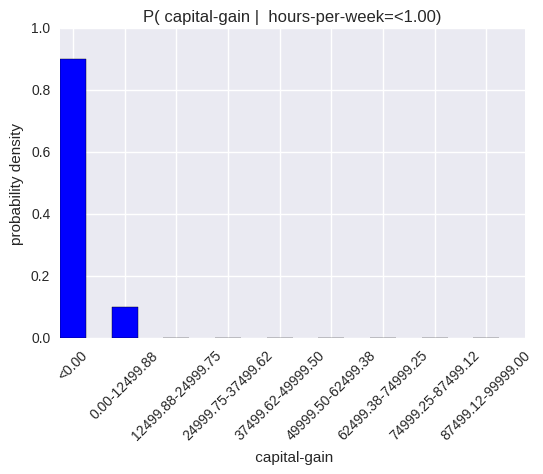

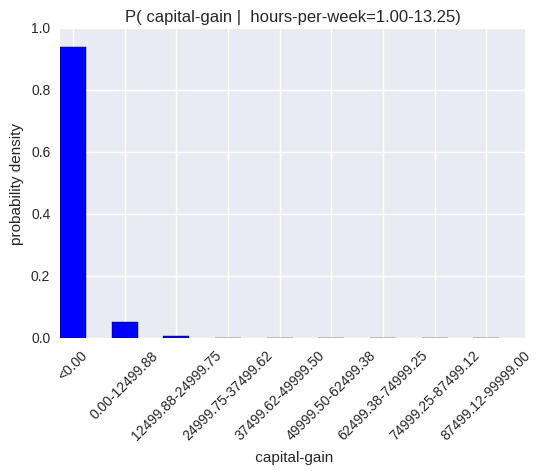

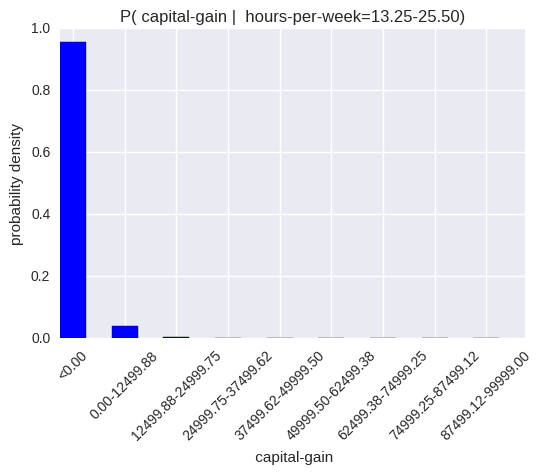

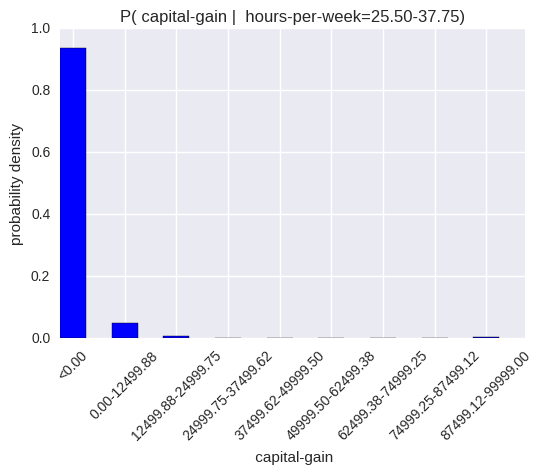

In [23]:
#plot_density_1d([11],{0:0,6:2})
for hpw in range(0,4):
    plot_density_1d([8],{10:hpw})

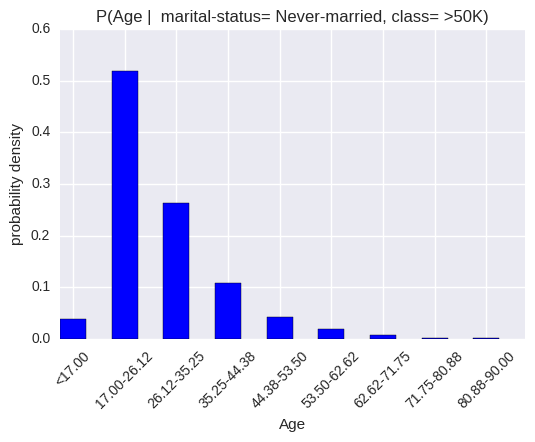

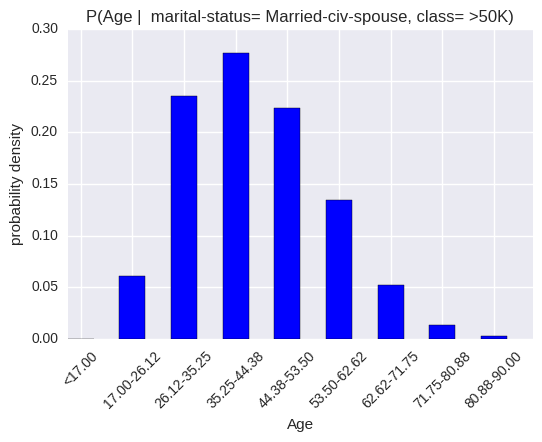

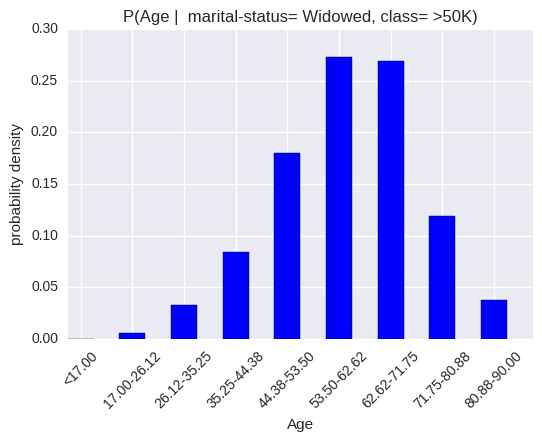

In [24]:
plot_density_1d([0],{11:0, 4:5})
plot_density_1d([0],{11:0, 4:6})
plot_density_1d([0],{11:0, 4:3})

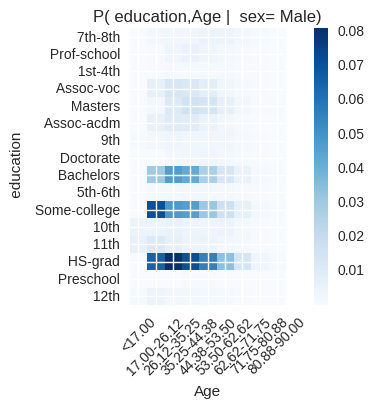

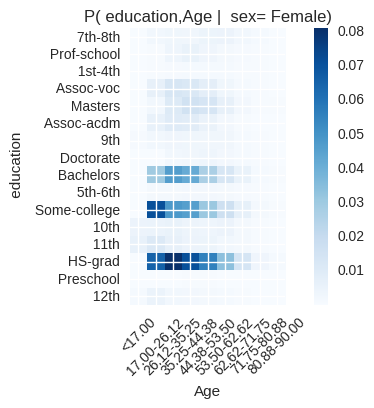

In [25]:

plot_density_2d(enum=[2,0], evidence={7:0})
plot_density_2d(enum=[2,0], evidence={7:1})



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:79: RuntimeWarning: divide by zero encountered in log10


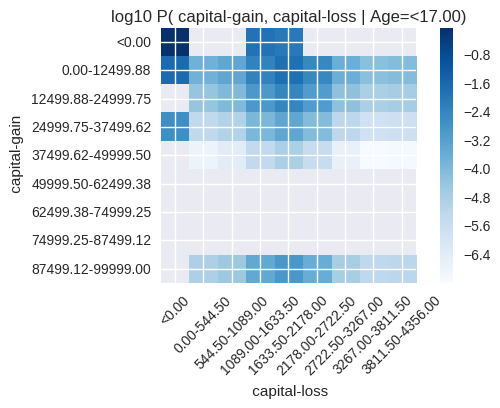

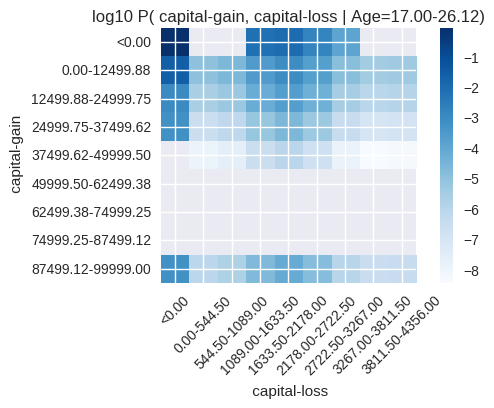

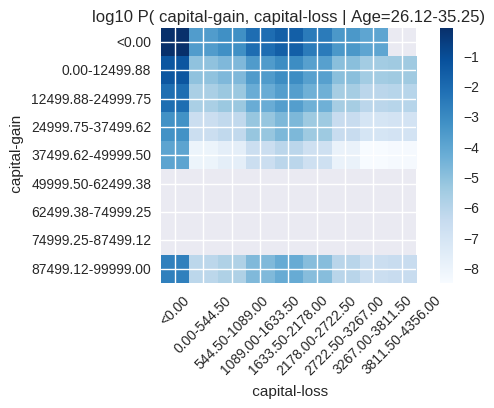

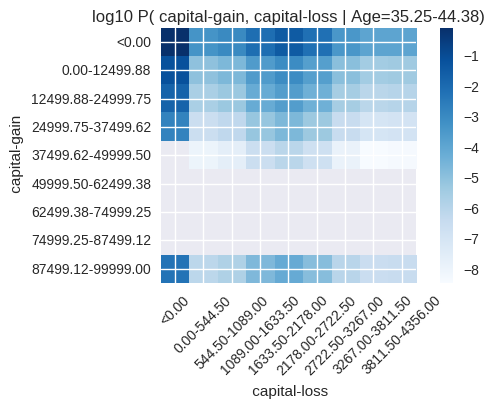

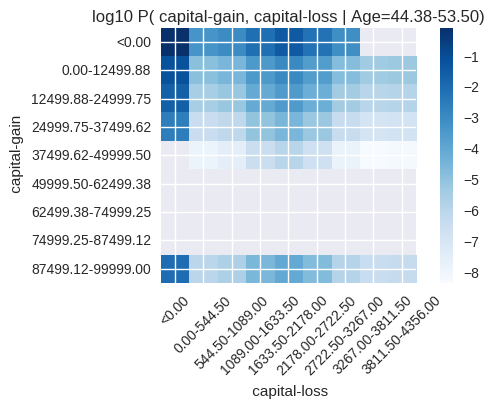

In [26]:
for i in range(0,5):
    plot_density_2d(enum=[8,9], evidence={0:i},log=True)

#plot_density_2d(enum=[8,9], evidence={0:0})
#plot_density_2d(enum=[8,9], evidence={7:1,11:0})

In [27]:
print "Notebook finished in %f seconds"%(time.time()-t0)

Notebook finished in 6.701123 seconds
